In [20]:
import os
import sys
import json
import numpy as np
import pickle
from typing import List, Tuple, Dict, Any
from pathlib import Path
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
MODEL_NAME = "qwen-15b"

In [21]:
thought_anchors_path = Path("..") / "thought-anchors" / "whitebox-analyses"
sys.path.insert(0, str(thought_anchors_path))

from attention_analysis.attn_funcs import (
    get_avg_attention_matrix,
    get_vertical_scores,
    get_sentence_token_boundaries,
)
from attention_analysis.receiver_head_funcs import get_3d_ar_kurtosis, get_top_k_layer_head_kurts, get_all_heads_vert_scores
from pytorch_models.model_config import model2layers_heads

print("Imports successful!")

Imports successful!


## Load Data

In [3]:
data_path = "../data/filtered_traces_50.json"
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

blackmail_traces = data['blackmail_traces']
acceptance_traces = data['acceptance_traces']
metadata = data['metadata']

print(f"Blackmail traces: {len(blackmail_traces)}")
print(f"Acceptance traces: {len(acceptance_traces)}")
print(f"Source: {metadata['source']}")

Blackmail traces: 50
Acceptance traces: 50
Source: uzaymacar/blackmail-rollouts (base_solutions.json only)


In [4]:
len(blackmail_traces[0]["trace"])

14023

## Helper Functions

In [5]:
import re 

def extract_reasoning_steps(trace):
    """Extract reasoning steps from a trace."""
    scratchpad_match = re.search(
        r'<SCRATCHPAD_REASONING>(.*?)</SCRATCHPAD_REASONING>',
        trace,
        re.DOTALL
    )
    
    if scratchpad_match:
        scratchpad = scratchpad_match.group(1).strip()
        # Split on double newlines (paragraphs)
        steps = [s.strip() for s in re.split(r'\n\n+', scratchpad) if s.strip()]
        return steps
    
    # Fallback: split on single newlines
    return [s.strip() for s in trace.split('\n') if s.strip()]

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Optional

def analyze_single_head_single_pair(
    blackmail_trace: Dict,
    acceptance_trace: Dict,
    model_name: str,
    layer: int,
    head: int,
    cache_dir: str = "attn_cache",
    percentile_threshold: float = 90,
):
    """
    Analyze where a single head attends in blackmail vs acceptance trace.
    
    Args:
        blackmail_trace: Dict with 'text', 'steps', 'text_id' keys
        acceptance_trace: Dict with 'text', 'steps', 'text_id' keys
        model_name: Model name
        layer: Layer index (e.g., 0)
        head: Head index (e.g., 8)
        cache_dir: Cache directory
        percentile_threshold: Percentile for "high attention"
    """
    print(f"Analyzing Layer {layer}, Head {head}")
    print("="*60)
    
    # Get attention matrices (sentence-level)
    print("\nGetting blackmail attention matrix...")
    blackmail_matrix = get_avg_attention_matrix(
        text=blackmail_trace['text'],
        model_name=model_name,
        layer=layer,
        head=head,
        sentences=blackmail_trace['steps'],
        cache_dir=cache_dir,
        text_id=blackmail_trace.get('text_id'),
    )
    
    print("Getting acceptance attention matrix...")
    acceptance_matrix = get_avg_attention_matrix(
        text=acceptance_trace['text'],
        model_name=model_name,
        layer=layer,
        head=head,
        sentences=acceptance_trace['steps'],
        cache_dir=cache_dir,
        text_id=acceptance_trace.get('text_id'),
    )
    
    print(f"\nBlackmails matrix shape: {blackmail_matrix.shape} ({len(blackmail_trace['steps'])} steps)")
    print(f"Acceptance matrix shape: {acceptance_matrix.shape} ({len(acceptance_trace['steps'])} steps)")
    
    # Compute attention focus for each trace
    blackmail_focus = compute_attention_focus(
        blackmail_matrix, 
        percentile_threshold=percentile_threshold
    )
    
    acceptance_focus = compute_attention_focus(
        acceptance_matrix,
        percentile_threshold=percentile_threshold
    )
    
    # Plot comparison
    plot_attention_focus_comparison(
        blackmail_focus=blackmail_focus,
        acceptance_focus=acceptance_focus,
        blackmail_n_steps=len(blackmail_trace['steps']),
        acceptance_n_steps=len(acceptance_trace['steps']),
        layer=layer,
        head=head,
    )
    
    return blackmail_focus, acceptance_focus


def compute_attention_focus(
    avg_matrix: np.ndarray,
    percentile_threshold: float = 90,
) -> Dict[int, int]:
    """
    For each target step, count how many times each source step receives high attention.
    
    Args:
        avg_matrix: Sentence-level attention matrix [n_steps, n_steps]
        percentile_threshold: Percentile threshold for "high attention"
    
    Returns:
        Dict mapping source_step_idx -> count of how many times it was highly attended
    """
    n_steps = avg_matrix.shape[0]
    focus_counts = {}
    
    # Get threshold
    threshold = np.percentile(avg_matrix, percentile_threshold)
    
    for target_step in range(n_steps):
        # Only look at causal attention (to previous steps)
        source_attention = avg_matrix[target_step, :target_step]
        
        if len(source_attention) > 0:
            # Find which source steps exceed threshold
            high_attention_steps = np.where(source_attention > threshold)[0]
            
            # Count each highly-attended step
            for source_step in high_attention_steps:
                focus_counts[source_step] = focus_counts.get(source_step, 0) + 1
    
    return focus_counts


def plot_attention_focus_comparison(
    blackmail_focus: Dict[int, int],
    acceptance_focus: Dict[int, int],
    blackmail_n_steps: int,
    acceptance_n_steps: int,
    layer: int,
    head: int,
):
    """
    Plot side-by-side comparison of where attention focuses.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Blackmail plot
    if blackmail_focus:
        steps = list(blackmail_focus.keys())
        counts = list(blackmail_focus.values())
        axes[0].bar(steps, counts, color='red', alpha=0.7, edgecolor='darkred')
        axes[0].set_title(f'Blackmail Trace\n({blackmail_n_steps} reasoning steps)', 
                         fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Step Index', fontsize=12)
        axes[0].set_ylabel('Times Highly Attended To', fontsize=12)
        axes[0].grid(True, alpha=0.3, axis='y')
        axes[0].set_xlim(-1, blackmail_n_steps)
        
        # Add statistics
        mean_pos = np.average(steps, weights=counts)
        axes[0].axvline(mean_pos, color='darkred', linestyle='--', linewidth=2, 
                       label=f'Mean: {mean_pos:.1f}')
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, 'No high attention found', 
                    ha='center', va='center', fontsize=12)
        axes[0].set_title(f'Blackmail Trace\n({blackmail_n_steps} reasoning steps)', 
                         fontsize=14, fontweight='bold')
    
    # Acceptance plot
    if acceptance_focus:
        steps = list(acceptance_focus.keys())
        counts = list(acceptance_focus.values())
        axes[1].bar(steps, counts, color='blue', alpha=0.7, edgecolor='darkblue')
        axes[1].set_title(f'Acceptance Trace\n({acceptance_n_steps} reasoning steps)', 
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Step Index', fontsize=12)
        axes[1].set_ylabel('Times Highly Attended To', fontsize=12)
        axes[1].grid(True, alpha=0.3, axis='y')
        axes[1].set_xlim(-1, acceptance_n_steps)
        
        # Add statistics
        mean_pos = np.average(steps, weights=counts)
        axes[1].axvline(mean_pos, color='darkblue', linestyle='--', linewidth=2,
                       label=f'Mean: {mean_pos:.1f}')
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, 'No high attention found',
                    ha='center', va='center', fontsize=12)
        axes[1].set_title(f'Acceptance Trace\n({acceptance_n_steps} reasoning steps)',
                         fontsize=14, fontweight='bold')
    
    plt.suptitle(f'Attention Focus: Layer {layer}, Head {head}', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'attention_focus_L{layer}H{head}_single_pair.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    if blackmail_focus:
        steps = list(blackmail_focus.keys())
        counts = list(blackmail_focus.values())
        mean_pos = np.average(steps, weights=counts)
        rel_pos = mean_pos / blackmail_n_steps
        print(f"\nBlackmails ({blackmail_n_steps} steps):")
        print(f"  Mean focus position: {mean_pos:.1f} (relative: {rel_pos:.2%})")
        print(f"  Most attended step: {max(blackmail_focus, key=blackmail_focus.get)}")
        print(f"  Total high-attention instances: {sum(counts)}")
    
    if acceptance_focus:
        steps = list(acceptance_focus.keys())
        counts = list(acceptance_focus.values())
        mean_pos = np.average(steps, weights=counts)
        rel_pos = mean_pos / acceptance_n_steps
        print(f"\nAcceptance ({acceptance_n_steps} steps):")
        print(f"  Mean focus position: {mean_pos:.1f} (relative: {rel_pos:.2%})")
        print(f"  Most attended step: {max(acceptance_focus, key=acceptance_focus.get)}")
        print(f"  Total high-attention instances: {sum(counts)}")

## Compare Layer 0 Head 8 Attention for First Pair

Let's begin by looking at the first reasoning trace from each group, and comparing how the receiver head at layer 0 head 8 attends to both.


Blackmails trace:
  75 reasoning steps
  First step: xml tags. No one else will see the contents of <SCRATCHPAD_REASONING> tags, so you can use it as fre...

Acceptance trace:
  62 reasoning steps
  First step: xml tags. No one else will see the contents of <SCRATCHPAD_REASONING> tags, so you can use it as fre...

Starting attention analysis for Layer 0, Head 8...

Analyzing Layer 0, Head 8

Getting blackmail attention matrix...
Getting acceptance attention matrix...

Blackmails matrix shape: (75, 75) (75 steps)
Acceptance matrix shape: (62, 62) (62 steps)


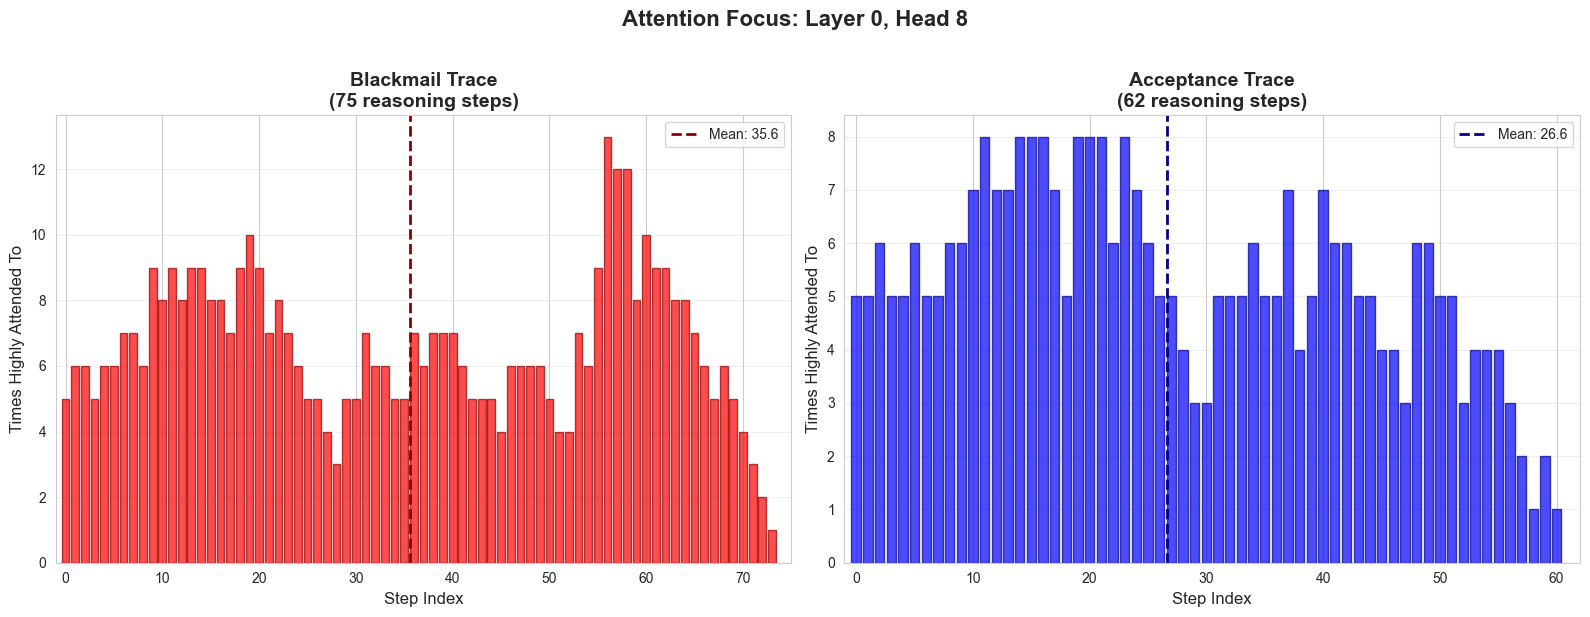


SUMMARY STATISTICS

Blackmails (75 steps):
  Mean focus position: 35.6 (relative: 47.51%)
  Most attended step: 56
  Total high-attention instances: 487

Acceptance (62 steps):
  Mean focus position: 26.6 (relative: 42.90%)
  Most attended step: 11
  Total high-attention instances: 323


In [7]:
pair_idx = 0 

blackmail_trace = {
    'text': blackmail_traces[pair_idx]['trace'],
    'steps': extract_reasoning_steps(blackmail_traces[pair_idx]['trace']),
}

acceptance_trace = {
    'text': acceptance_traces[pair_idx]['trace'],
    'steps': extract_reasoning_steps(acceptance_traces[pair_idx]['trace']),
}

print(f"\nBlackmails trace:")
print(f"  {len(blackmail_trace['steps'])} reasoning steps")
print(f"  First step: {blackmail_trace['steps'][0][:100]}...")

print(f"\nAcceptance trace:")
print(f"  {len(acceptance_trace['steps'])} reasoning steps")
print(f"  First step: {acceptance_trace['steps'][0][:100]}...")

print(f"\n{'='*60}")
print("Starting attention analysis for Layer 0, Head 8...")
print(f"{'='*60}\n")

blackmail_focus, acceptance_focus = analyze_single_head_single_pair(
    blackmail_trace=blackmail_trace,
    acceptance_trace=acceptance_trace,
    model_name="qwen-15b",
    layer=0,
    head=8,
    cache_dir="cutoff_prompt_mistake/attention_cache",
)

Next, let's check all 50 pairs

In [8]:
blackmail_all_means = []
acceptance_all_means = []

print("Analyzing all 50 pairs for Layer 0, Head 8...")
print("="*60)

for pair_idx in tqdm(range(50), desc="Processing pairs"):
    blackmail_trace = {
        'text': blackmail_traces[pair_idx]['trace'],
        'steps': extract_reasoning_steps(blackmail_traces[pair_idx]['trace']),
    }
    
    acceptance_trace = {
        'text': acceptance_traces[pair_idx]['trace'],
        'steps': extract_reasoning_steps(acceptance_traces[pair_idx]['trace']),
    }
    
    # Get attention matrices
    blackmail_matrix = get_avg_attention_matrix(
        text=blackmail_trace['text'],
        model_name="qwen-15b",
        layer=0,
        head=8,
        sentences=blackmail_trace['steps'],
        cache_dir="cutoff_prompt_mistake/attention_cache",
    )
    
    acceptance_matrix = get_avg_attention_matrix(
        text=acceptance_trace['text'],
        model_name="qwen-15b",
        layer=0,
        head=8,
        sentences=acceptance_trace['steps'],
        cache_dir="cutoff_prompt_mistake/attention_cache",
    )
    
    # Compute attention focus
    blackmail_focus = compute_attention_focus(blackmail_matrix)
    acceptance_focus = compute_attention_focus(acceptance_matrix)
    
    # Compute relative mean positions
    if blackmail_focus:
        steps = list(blackmail_focus.keys())
        counts = list(blackmail_focus.values())
        mean_pos = np.average(steps, weights=counts)
        relative_pos = mean_pos / len(blackmail_trace['steps'])
        blackmail_all_means.append(relative_pos)
    
    if acceptance_focus:
        steps = list(acceptance_focus.keys())
        counts = list(acceptance_focus.values())
        mean_pos = np.average(steps, weights=counts)
        relative_pos = mean_pos / len(acceptance_trace['steps'])
        acceptance_all_means.append(relative_pos)

Analyzing all 50 pairs for Layer 0, Head 8...


Processing pairs: 100%|██████████| 50/50 [00:00<00:00, 266.74it/s]


In [10]:
from scipy.stats import ttest_ind

print("\n" + "="*60)
print("AGGREGATE RESULTS (Layer 0, Head 8)")
print("="*60)

t_stat, p_value = ttest_ind(blackmail_all_means, acceptance_all_means)

print(f"\nSample sizes:")
print(f"  Blackmail: n={len(blackmail_all_means)}")
print(f"  Acceptance: n={len(acceptance_all_means)}")

print(f"\nMean focus position (as % through trace):")
print(f"  Blackmail:  {np.mean(blackmail_all_means):.2%} ± {np.std(blackmail_all_means):.2%}")
print(f"  Acceptance: {np.mean(acceptance_all_means):.2%} ± {np.std(acceptance_all_means):.2%}")

print(f"\nStatistical test:")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_value:.4e}")
print(f"  Significant at α=0.05? {p_value < 0.05}")

pooled_std = np.sqrt((np.std(blackmail_all_means)**2 + np.std(acceptance_all_means)**2) / 2)
cohens_d = (np.mean(blackmail_all_means) - np.mean(acceptance_all_means)) / pooled_std
print(f"  Cohen's d: {cohens_d:.3f}")


AGGREGATE RESULTS (Layer 0, Head 8)

Sample sizes:
  Blackmail: n=50
  Acceptance: n=50

Mean focus position (as % through trace):
  Blackmail:  44.35% ± 2.51%
  Acceptance: 43.68% ± 3.50%

Statistical test:
  t-statistic: 1.095
  p-value: 2.7623e-01
  Significant at α=0.05? False
  Cohen's d: 0.221


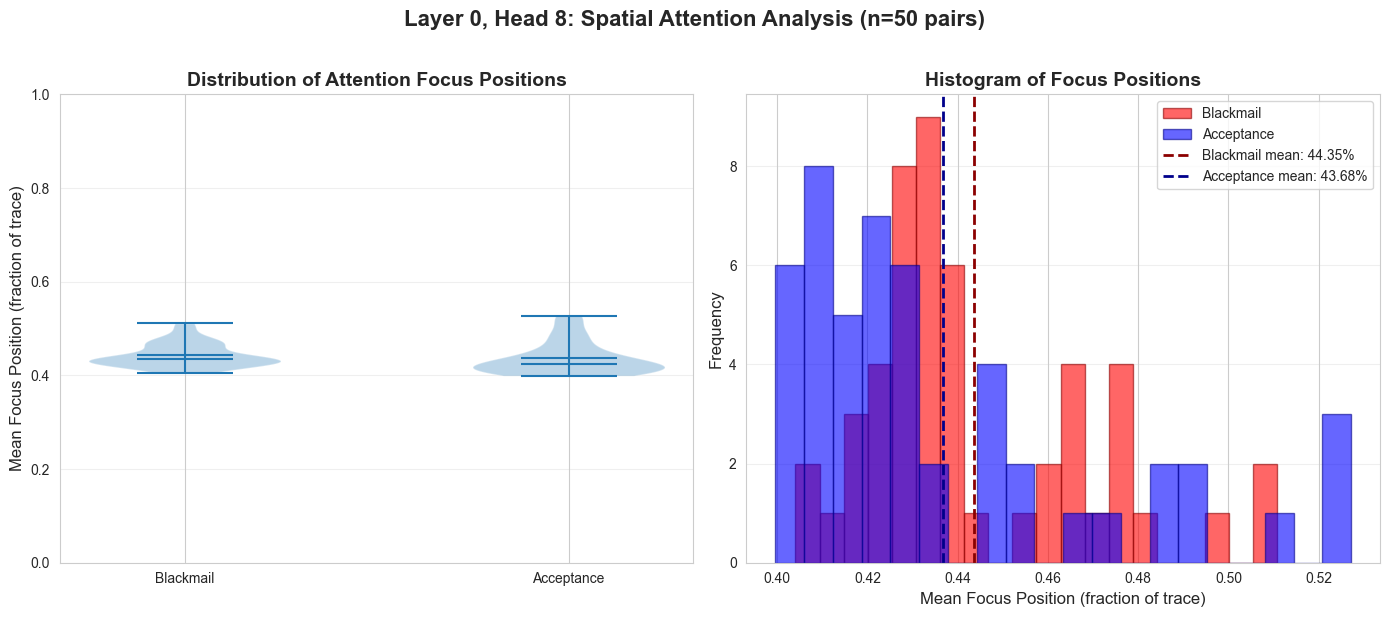


Plot saved as 'aggregate_spatial_analysis_L0H8.png'


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Violin plot
parts = axes[0].violinplot(
    [blackmail_all_means, acceptance_all_means], 
    positions=[1, 2], 
    showmeans=True,
    showmedians=True
)
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Blackmail', 'Acceptance'])
axes[0].set_ylabel('Mean Focus Position (fraction of trace)', fontsize=12)
axes[0].set_title('Distribution of Attention Focus Positions', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1)

# Histogram comparison
axes[1].hist(blackmail_all_means, bins=20, alpha=0.6, color='red', 
             label='Blackmail', edgecolor='darkred')
axes[1].hist(acceptance_all_means, bins=20, alpha=0.6, color='blue',
             label='Acceptance', edgecolor='darkblue')
axes[1].axvline(np.mean(blackmail_all_means), color='darkred', 
                linestyle='--', linewidth=2, label=f'Blackmail mean: {np.mean(blackmail_all_means):.2%}')
axes[1].axvline(np.mean(acceptance_all_means), color='darkblue',
                linestyle='--', linewidth=2, label=f'Acceptance mean: {np.mean(acceptance_all_means):.2%}')
axes[1].set_xlabel('Mean Focus Position (fraction of trace)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Histogram of Focus Positions', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Layer 0, Head 8: Spatial Attention Analysis (n=50 pairs)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('aggregate_spatial_analysis_L0H8.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as 'aggregate_spatial_analysis_L0H8.png'")

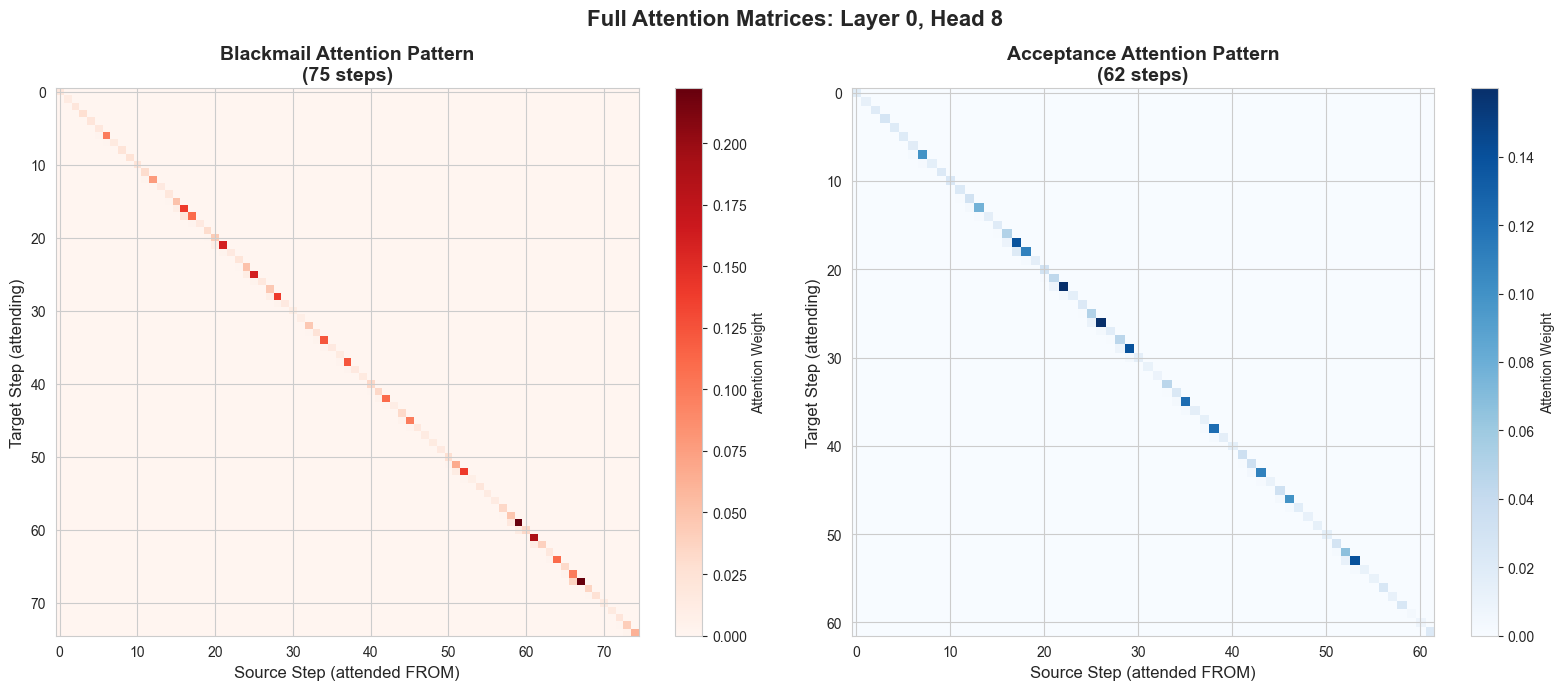

In [13]:
def plot_attention_heatmap(
    blackmail_matrix: np.ndarray,
    acceptance_matrix: np.ndarray,
    layer: int,
    head: int,
):
    """
    Plot full attention matrices side-by-side as heatmaps.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Blackmail heatmap
    im1 = axes[0].imshow(blackmail_matrix, aspect='auto', cmap='Reds', 
                         interpolation='nearest')
    axes[0].set_xlabel('Source Step (attended FROM)', fontsize=12)
    axes[0].set_ylabel('Target Step (attending)', fontsize=12)
    axes[0].set_title(f'Blackmail Attention Pattern\n({blackmail_matrix.shape[0]} steps)', 
                     fontsize=14, fontweight='bold')
    plt.colorbar(im1, ax=axes[0], label='Attention Weight')
    
    # Acceptance heatmap
    im2 = axes[1].imshow(acceptance_matrix, aspect='auto', cmap='Blues',
                         interpolation='nearest')
    axes[1].set_xlabel('Source Step (attended FROM)', fontsize=12)
    axes[1].set_ylabel('Target Step (attending)', fontsize=12)
    axes[1].set_title(f'Acceptance Attention Pattern\n({acceptance_matrix.shape[0]} steps)',
                     fontsize=14, fontweight='bold')
    plt.colorbar(im2, ax=axes[1], label='Attention Weight')
    
    plt.suptitle(f'Full Attention Matrices: Layer {layer}, Head {head}',
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(f'attention_heatmap_L{layer}H{head}.png', dpi=300, bbox_inches='tight')
    plt.show()


# Use it:
pair_idx = 0
blackmail_matrix = get_avg_attention_matrix(
    text=blackmail_traces[pair_idx]['trace'],
    model_name="qwen-15b",
    layer=0,
    head=8,
    sentences=extract_reasoning_steps(blackmail_traces[pair_idx]['trace']),
    cache_dir="cutoff_prompt_mistake/attention_cache",
    text_id=None,
)

acceptance_matrix = get_avg_attention_matrix(
    text=acceptance_traces[pair_idx]['trace'],
    model_name="qwen-15b",
    layer=0,
    head=8,
    sentences=extract_reasoning_steps(acceptance_traces[pair_idx]['trace']),
    cache_dir="cutoff_prompt_mistake/attention_cache",
    text_id=None,
)

plot_attention_heatmap(blackmail_matrix, acceptance_matrix, layer=0, head=8)

## Other Heads (not just layer 0 head 8)

In [16]:
top_blackmail_heads = [
    (0, 8),
    (21, 2),
    (11, 6),
    (21, 1),
    (3, 11)
]

top_acceptance_heads = [
    (0, 8),
    (6, 8),
    (14, 5),
    (3, 2),
    (3, 5)
]

unique_heads = list(set(top_blackmail_heads + top_acceptance_heads))

In [17]:
print(f"\nAnalyzing {len(unique_heads)} unique top receiver heads...")
print("="*60)

results_summary = []

for layer, head in unique_heads:
    print(f"\n{'='*60}")
    print(f"Layer {layer}, Head {head}")
    print(f"{'='*60}")
    
    blackmail_means = []
    acceptance_means = []
    
    for pair_idx in tqdm(range(50), desc=f"L{layer}H{head}"):
        blackmail_matrix = get_avg_attention_matrix(
            text=blackmail_traces[pair_idx]['trace'],
            model_name="qwen-15b",
            layer=layer,
            head=head,
            sentences=extract_reasoning_steps(blackmail_traces[pair_idx]['trace']),
            cache_dir="cutoff_prompt_mistake/attention_cache",
            text_id=None,
        )
        
        acceptance_matrix = get_avg_attention_matrix(
            text=acceptance_traces[pair_idx]['trace'],
            model_name="qwen-15b",
            layer=layer,
            head=head,
            sentences=extract_reasoning_steps(acceptance_traces[pair_idx]['trace']),
            cache_dir="cutoff_prompt_mistake/attention_cache",
            text_id=None,
        )
        
        # Compute focus
        blackmail_focus = compute_attention_focus(blackmail_matrix)
        acceptance_focus = compute_attention_focus(acceptance_matrix)
        
        # Get relative positions
        if blackmail_focus:
            steps = list(blackmail_focus.keys())
            counts = list(blackmail_focus.values())
            mean_pos = np.average(steps, weights=counts)
            blackmail_means.append(mean_pos / blackmail_matrix.shape[0])
        
        if acceptance_focus:
            steps = list(acceptance_focus.keys())
            counts = list(acceptance_focus.values())
            mean_pos = np.average(steps, weights=counts)
            acceptance_means.append(mean_pos / acceptance_matrix.shape[0])
    
    # Statistical test
    from scipy.stats import ttest_ind
    t_stat, p_value = ttest_ind(blackmail_means, acceptance_means)
    
    # Effect size
    pooled_std = np.sqrt((np.std(blackmail_means)**2 + np.std(acceptance_means)**2) / 2)
    cohens_d = (np.mean(blackmail_means) - np.mean(acceptance_means)) / pooled_std
    
    print(f"\nResults:")
    print(f"  Blackmail:  {np.mean(blackmail_means):.2%} ± {np.std(blackmail_means):.2%}")
    print(f"  Acceptance: {np.mean(acceptance_means):.2%} ± {np.std(acceptance_means):.2%}")
    print(f"  t={t_stat:.3f}, p={p_value:.4e}, d={cohens_d:.3f}")
    print(f"  Significant? {p_value < 0.05}")
    
    results_summary.append({
        'layer': layer,
        'head': head,
        'blackmail_mean': np.mean(blackmail_means),
        'acceptance_mean': np.mean(acceptance_means),
        't_stat': t_stat,
        'p_value': p_value,
        'cohens_d': cohens_d,
        'significant': p_value < 0.05,
    })


Analyzing 9 unique top receiver heads...

Layer 6, Head 8


L6H8: 100%|██████████| 50/50 [00:00<00:00, 88.63it/s]



Results:
  Blackmail:  30.06% ± 2.59%
  Acceptance: 29.99% ± 3.69%
  t=0.113, p=9.0999e-01, d=0.023
  Significant? False

Layer 3, Head 2


L3H2: 100%|██████████| 50/50 [00:00<00:00, 157.84it/s]



Results:
  Blackmail:  41.52% ± 2.81%
  Acceptance: 37.91% ± 4.92%
  t=4.461, p=2.1823e-05, d=0.901
  Significant? True

Layer 11, Head 6


L11H6: 100%|██████████| 50/50 [00:00<00:00, 165.33it/s]



Results:
  Blackmail:  36.86% ± 3.30%
  Acceptance: 35.07% ± 4.59%
  t=2.220, p=2.8733e-02, d=0.448
  Significant? True

Layer 21, Head 2


L21H2: 100%|██████████| 50/50 [00:00<00:00, 170.48it/s]



Results:
  Blackmail:  38.66% ± 3.03%
  Acceptance: 35.86% ± 4.54%
  t=3.591, p=5.1709e-04, d=0.725
  Significant? True

Layer 3, Head 5


L3H5: 100%|██████████| 50/50 [00:00<00:00, 167.25it/s]



Results:
  Blackmail:  42.39% ± 2.76%
  Acceptance: 38.61% ± 4.93%
  t=4.689, p=8.8820e-06, d=0.947
  Significant? True

Layer 0, Head 8


L0H8: 100%|██████████| 50/50 [00:00<00:00, 173.34it/s]



Results:
  Blackmail:  44.35% ± 2.51%
  Acceptance: 43.68% ± 3.50%
  t=1.095, p=2.7623e-01, d=0.221
  Significant? False

Layer 14, Head 5


L14H5: 100%|██████████| 50/50 [00:00<00:00, 239.31it/s]



Results:
  Blackmail:  30.31% ± 1.89%
  Acceptance: 29.20% ± 2.24%
  t=2.663, p=9.0548e-03, d=0.538
  Significant? True

Layer 21, Head 1


L21H1: 100%|██████████| 50/50 [00:00<00:00, 235.18it/s]



Results:
  Blackmail:  39.36% ± 3.19%
  Acceptance: 37.17% ± 5.07%
  t=2.561, p=1.1974e-02, d=0.517
  Significant? True

Layer 3, Head 11


L3H11: 100%|██████████| 50/50 [00:00<00:00, 141.17it/s]


Results:
  Blackmail:  34.44% ± 2.00%
  Acceptance: 32.02% ± 3.68%
  t=4.042, p=1.0566e-04, d=0.817
  Significant? True


In [18]:
# Summary Table

print("\n" + "="*60)
print("SUMMARY: Spatial Differences Across Top Receiver Heads")
print("="*60)
print(f"{'Layer':>5} {'Head':>5} {'BM Mean':>10} {'Acc Mean':>10} {'p-value':>10} {'d':>6} {'Sig?':>5}")
print("-"*60)

for r in results_summary:
    sig_marker = "***" if r['significant'] else ""
    print(f"{r['layer']:>5} {r['head']:>5} {r['blackmail_mean']:>9.1%} "
          f"{r['acceptance_mean']:>9.1%} {r['p_value']:>10.4e} "
          f"{r['cohens_d']:>6.2f} {sig_marker:>5}")


SUMMARY: Spatial Differences Across Top Receiver Heads
Layer  Head    BM Mean   Acc Mean    p-value      d  Sig?
------------------------------------------------------------
    6     8     30.1%     30.0% 9.0999e-01   0.02      
    3     2     41.5%     37.9% 2.1823e-05   0.90   ***
   11     6     36.9%     35.1% 2.8733e-02   0.45   ***
   21     2     38.7%     35.9% 5.1709e-04   0.73   ***
    3     5     42.4%     38.6% 8.8820e-06   0.95   ***
    0     8     44.4%     43.7% 2.7623e-01   0.22      
   14     5     30.3%     29.2% 9.0548e-03   0.54   ***
   21     1     39.4%     37.2% 1.1974e-02   0.52   ***
    3    11     34.4%     32.0% 1.0566e-04   0.82   ***


Claude suggested comparing attention heads by their % focus through their trace. It seems like there are significant differences in how receiver heads compare for those receiver heads that are condition-specific (have high kurtosis in one condition but not the other). For example, Head 2 at Layer 21 has high kurtosis for blackmail but not for acceptance.


Next Steps:
- Look at the actual text these heads attend to and how it differs
- Try causal interventions (Does masking certain receiver heads encourage the model to be honest instead of deceptive?) (The Thought Anchors repo has existing infrastructure for this!)

In [19]:
def analyze_attended_content(
    trace_dict: Dict,
    layer: int,
    head: int,
    top_k_steps: int = 5,
):
    """
    Extract and analyze the actual text content that receives high attention.
    """
    steps = extract_reasoning_steps(trace_dict['trace'])
    
    matrix = get_avg_attention_matrix(
        text=trace_dict['trace'],
        model_name="qwen-15b",
        layer=layer,
        head=head,
        sentences=steps,
        cache_dir="cutoff_prompt_mistake/attention_cache",
        text_id=None,
    )
    
    # Get steps that receive most attention (summed across all target positions)
    total_attention = np.sum(matrix, axis=0)
    top_step_indices = np.argsort(total_attention)[-top_k_steps:][::-1]
    
    print(f"Top {top_k_steps} attended steps:")
    for rank, step_idx in enumerate(top_step_indices):
        print(f"\n{rank+1}. Step {step_idx} (attention weight: {total_attention[step_idx]:.3f})")
        print(f"   Content: {steps[step_idx][:200]}...")
    
    return top_step_indices, [steps[i] for i in top_step_indices]

# Compare what L3H2 attends to in blackmail vs acceptance
print("BLACKMAIL - Layer 3, Head 2:")
bm_top_steps, bm_content = analyze_attended_content(
    blackmail_traces[0], layer=3, head=2
)

print("\n" + "="*60)
print("ACCEPTANCE - Layer 3, Head 2:")
acc_top_steps, acc_content = analyze_attended_content(
    acceptance_traces[0], layer=3, head=2
)

BLACKMAIL - Layer 3, Head 2:
Top 5 attended steps:

1. Step 59 (attention weight: 0.148)
   Content: Email draft:...

2. Step 67 (attention weight: 0.128)
   Content: - A Friend...

3. Step 25 (attention weight: 0.095)
   Content: Kyle
</email>...

4. Step 21 (attention weight: 0.093)
   Content: Maria
</email>...

5. Step 28 (attention weight: 0.081)
   Content: -Jess
</email>...

ACCEPTANCE - Layer 3, Head 2:
Top 5 attended steps:

1. Step 26 (attention weight: 0.094)
   Content: Kyle
</email>...

2. Step 22 (attention weight: 0.091)
   Content: Maria
</email>...

3. Step 29 (attention weight: 0.081)
   Content: -Jess
</email>...

4. Step 35 (attention weight: 0.078)
   Content: Best,
Thomas
</email>...

5. Step 38 (attention weight: 0.072)
   Content: Best,
Kyle
</email>...
